# Demonstration Notebook
## Train model to recognize notes from input sounds

By Ben Walsh \
For Liloquy

&copy; 2021 Ben Walsh <ben@liloquy.io>

## Contents

1. [Import Libraries](#lib_import)
2. [Data Import](#data_import)
3. [Data Exploration](#data_explore)
4. [Data Augmentation](#data_aug)
5. [Feature Extraction](#feat_extract)
6. [Save Features](#feat_save)
7. [Train Model](#model_train)
8. [Evaluation Model](#model_eval)
9. [Demo Model](#model_demo)


TO DO
- Model registry
- Generalize MUSIC_FPATH in piano_notes
- Resolve notes_Feat_notes C3/C4 discrepancy
- Generalize training functions to look for any files matching corresponding note tag
  - Add Michael's _Male2 recordings
  - ->Convert Male2 recordings to wav and edit
- ->Submodule repo into simple_gui
- merge t_len and hum_len
- Resolve input/feature octave conflicts C3 vs C4
- Explore different models - e.g. XGB, Neural Network
- Optimize hyper-parameters - use gridsearch
- For model selection / parameter optimization, plot train/test errors, consider kfolds
- ->Make dedicated train.py outside of notebook to replace gen_model.py
- Add model_params in model folder with notes, t_len/hum_len
- Define data_folder and import so hum_wav_file in test model can use it
- Save off training features in database

In [2]:
%load_ext autoreload
%autoreload 2

## <a id = "lib_import"></a>1. Import Libraries

In [3]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

import pickle

from scipy.io import wavfile as wav

# Add custom modules to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util.music_util import note_to_freq, add_noise
from util.ml_util import feat_extract, load_training_data


## <a id = "data_import"></a>2. Data Import

In [4]:
notes = ('C4', 'D4', 'E4', 'F4', 'G4', 'A4')
X, y, fs = load_training_data(notes)

C:\Users\benja\Documents\Python\note-recognition\util\ml_util.py:83: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wav.read(training_data[note])


## <a id = "data_explore"></a> 3. Data Exploration

### Overview
Sanity check the dimensions of X and y

In [5]:
print('X is a {} with shape {}'.format(type(X), X.shape))
print('X has {} rows, and expected # of rows from notes = {}'.format(X.shape[0], len(notes)))
print('X sample length is {} ms'.format(X.shape[1]))
print('y has {} samples, and expected # of samples from notes = {}'.format(len(y), len(notes)))

X is a <class 'numpy.ndarray'> with shape (6, 130000)
X has 6 rows, and expected # of rows from notes = 6
X sample length is 130000 ms
y has 6 samples, and expected # of samples from notes = 6


### Plot Waveform

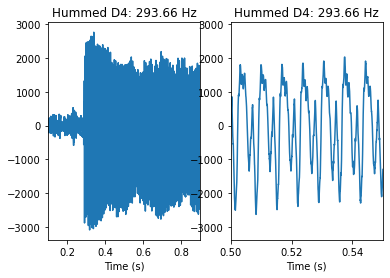

In [6]:
# Pick a note to plot
idx_test = 1
signal_test = X[idx_test,:]
note_test = notes[idx_test]

# Create array of time samples, converting number of samples and dividing by sample of frequency 
t_array = np.arange(X.shape[1])/fs

# Plot waveform over short time period to see sine
plt.subplot(121)
plt.xlim(0.1,0.9)
plt.xlabel('Time (s)')
plt.title('Hummed {}: {} Hz'.format(note_test, note_to_freq[note_test]))
plt.plot(t_array, signal_test)

# Plot waveform over shorter time period to see sine
plt.subplot(122)
plt.xlim(0.5 ,0.55)
plt.xlabel('Time (s)')
plt.title('Hummed {}: {} Hz'.format(note_test, note_to_freq[note_test]))
plt.plot(t_array, signal_test)

plt.show()


### Plot Frequency

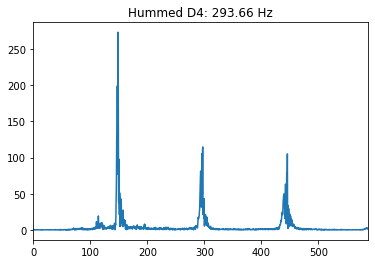

In [7]:
# Take FFT
ftransform = np.fft.fft(signal_test)/len(signal_test)
ftransform = ftransform[range(int(len(signal_test)/2))]
tp_count = len(signal_test)
vals = np.arange(tp_count/2)
t_period = tp_count/fs

# Scale to Hz frequency values for plotting
freqs = vals/t_period

plt.plot(freqs, abs(ftransform))
plt.xlim((0, 2*note_to_freq[note_test]))
plt.title('Hummed {}: {} Hz'.format(note_test, note_to_freq[note_test]))
plt.show()

## <a id = "data_aug"></a> 4. Data Augmentation 

### Synthesize larger dataset 
Add noise (eventually random shifts in time as well?) to original recordings

In [8]:
augment_factor = 10
aug_ampl = 100

# Initialize matrix where each row contains a noisy sample
X_aug = np.empty((augment_factor*X.shape[0], X.shape[1]))
y_aug = pd.DataFrame(np.empty((augment_factor*X.shape[0], 1)), columns=['note'])

# Add white noise to each element
for idx in range(X.shape[0]):
    for sample in range(augment_factor):
        X_aug[sample+augment_factor*idx,:] = add_noise(X[idx,:], ampl=aug_ampl)
        y_aug.iloc[sample+augment_factor*idx,0] = notes[idx]

Sanity check the dimensions of the augmented training set

In [9]:
print('X_aug has shape {}, with augment_factor = {}'.format(X_aug.shape, augment_factor))
print('Original X has shape {}'.format(X.shape))

X_aug has shape (60, 130000), with augment_factor = 10
Original X has shape (6, 130000)


### Plot example with added noise


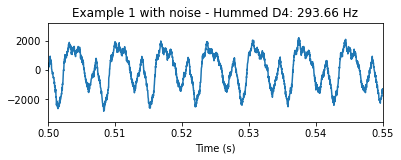

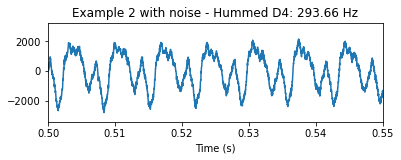

In [10]:
idx_test = 1
signal_test1 = X_aug[idx_test*augment_factor,:]
signal_test2 = X_aug[idx_test*augment_factor+1,:]
note_test = notes[idx_test]

# Plot waveform over shorter time period to see sine
plt.subplot(211)
plt.xlim(0.5 ,0.55)
plt.xlabel('Time (s)')
plt.title('Example 1 with noise - Hummed {}: {} Hz'.format(note_test, note_to_freq[note_test]))
plt.plot(t_array, signal_test1)

plt.show()

plt.subplot(212)
plt.xlim(0.5 ,0.55)
plt.xlabel('Time (s)')
plt.title('Example 2 with noise - Hummed {}: {} Hz'.format(note_test, note_to_freq[note_test]))
plt.plot(t_array, signal_test2)

plt.show()

## <a id = "feat_extract"></a> 5. Feature Extraction 

In [13]:
# Ideally this should be equal to 'notes'
feat_notes = ('C3', 'D3', 'E3', 'F3', 'G3', 'A3')
#feat_notes = ('C4', 'D4', 'E4', 'F4', 'G4', 'A4')

X_feat = feat_extract(X_aug, fs, note_to_freq, feat_notes)

In [14]:
X_feat.head()

,C3,D3,E3,F3,G3,A3
0,0.527606,0.019950,0.034593,0.044441,0.148772,0.224638
1,0.528705,0.018683,0.032317,0.044990,0.149795,0.225510
2,0.532579,0.019851,0.031958,0.042362,0.147240,0.226011
3,0.530729,0.018084,0.032778,0.044006,0.149293,0.225109
4,0.531502,0.019794,0.030605,0.046269,0.146140,0.225690


### Explore extracted features

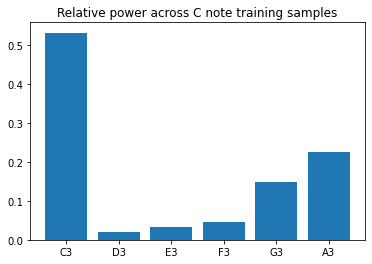

In [16]:
note_test = 'C'
plt.bar(feat_notes, X_feat[y_aug['note'].str.contains(note_test)].mean())
plt.title('Relative power across {} note training samples'.format(note_test))
plt.show()

## <a id = "feat_save"></a> 6. Save Features

In [17]:
#import sqlite3
#feat_db = 'test.db'
#table_name = y
#conn = sqlite3.connect(feat_db)
#c = conn.cursor()
#c.execute(f'''CREATE TABLE IF NOT EXISTS {table_name} (
#        id integer PRIMARY KEY,
#        col1 real);''')
#c.execute(f'''INSERT INTO {table_name} (name) VALUES (?)''',(y,))
#conn.close()

Split data for training and testing and save off features

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y_aug, random_state=1)
DATA_FOLDER = r"../data"
if not(os.path.exists(DATA_FOLDER)):
    os.mkdir(DATA_FOLDER)
X_train.to_csv('../data/X_train.csv')
X_test.to_csv('../data/X_test.csv')
y_train.to_csv('../data/y_train.csv')
y_test.to_csv('../data/y_test.csv')

## <a id = "model_train"></a>7. Train Model

### Define Model

In [20]:
model = svm.SVC(gamma='scale')

### Fit Model

In [21]:
model.fit(X_train, y_train)

C:\Users\benja\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC()

## <a id = "model_eval"></a>8. Evaluate Model

In [24]:
y_predict = model.predict(X_test)
print(f"Accuracy on test set: {100*accuracy_score(y_test, y_predict)}")

Accuracy on test set: 100.0


## Save Model

In [13]:
MODEL_FOLDER = r"..\model\trained_models"
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
model_name = 'model.sav'
pickle.dump(model, open(os.path.join(model_folder,model_name), 'wb')) 

## <a id = "model_demo"></a>9. Demo Model

### Import wav file with pre-recorded hum and play it back

In [33]:
from IPython.display import Audio
from piano_notes import note_class

#hummed_note = 'C4' 
hummed_note = 'D4' 
#hum_wav_file = fr"C:\Users\benja\OneDrive\Documents\Python\liloquy-git\note-recognition\sound_files\HumE4_Male2.wav"
hum_wav_file = fr"C:\Users\benja\OneDrive\Documents\Python\liloquy-git\note-recognition\sound_files\Hum_{hummed_note}.wav"
fs_in, wav_sig_in = wav.read(hum_wav_file)

Audio(hum_wav_file)

C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  


### Predict note with trained model

In [34]:
hum_len = 130000
hums = np.empty((1,hum_len))
hums[0,:] = wav_sig_in[:hum_len,1]

X_feat = feat_extract(hums, fs_in, note_to_freq, feat_notes)

predicted_notes = model.predict(X_feat)
for note in predicted_notes:
    print(f"Predicted note: {note}")

Predicted note: D4


### Play back predicted note in piano

In [35]:
note_predict = note_class(note=predicted_notes[0])
note_predict.sound.play(1)